In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [5]:
import scanpy as sc

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

## Create dataloaders

Note: samples must have the same number of genes (and of course in the same order). They can, however, have different number of cells, but you'll only be able to use `batch_size = 1`, because we matrices with different sizes cannot form a tensor.

It is possible in the future, by flanking them with zeros and carefully masking them out in several steps.

In [7]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

train_Xs = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)
Validation data dimensions:
(5000, 374)


In [8]:
embed_config = {
    'embedType': 'transformer',
    'default': True,
    'd_input': p
}
model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_quality=[512, 256, 1], 
                      n_heads=1,
                      lbd=1.,
                      embed_config=embed_config).to('cuda')

RuntimeError: shape '[1, -1, 4, 32]' is invalid for input of size 374

In [9]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)

Epoch 0001 Train MSE 693.238 Validate MSE 1.072 Raw MSE 1.041
Epoch 0002 Train MSE 693.251 Validate MSE 1.063 Raw MSE 1.033
Epoch 0003 Train MSE 693.245 Validate MSE 1.010 Raw MSE 0.973
Epoch 0004 Train MSE 693.249 Validate MSE 1.054 Raw MSE 1.025
Epoch 0005 Train MSE 693.250 Validate MSE 1.039 Raw MSE 1.009
Epoch 0006 Train MSE 693.242 Validate MSE 1.031 Raw MSE 1.006
Epoch 0007 Train MSE 693.225 Validate MSE 1.036 Raw MSE 1.010
Epoch 0008 Train MSE 693.219 Validate MSE 1.050 Raw MSE 1.029
Epoch 0009 Train MSE 693.229 Validate MSE 1.056 Raw MSE 1.033
Epoch 0010 Train MSE 693.223 Validate MSE 1.016 Raw MSE 0.993
Epoch 0011 Train MSE 693.215 Validate MSE 1.048 Raw MSE 1.027
Epoch 0012 Train MSE 693.239 Validate MSE 1.011 Raw MSE 0.993
Epoch 0013 Train MSE 693.222 Validate MSE 1.019 Raw MSE 1.003
Epoch 0014 Train MSE 693.219 Validate MSE 1.038 Raw MSE 1.020
Epoch 0015 Train MSE 693.228 Validate MSE 1.042 Raw MSE 1.029
Epoch 0016 Train MSE 693.226 Validate MSE 1.017 Raw MSE 1.000
Epoch 00

In [10]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))

Epoch 0501 Train MSE 693.182 Validate MSE 1.011 Raw MSE 1.033
Epoch 0502 Train MSE 693.165 Validate MSE 0.988 Raw MSE 1.023
Epoch 0503 Train MSE 693.175 Validate MSE 0.971 Raw MSE 1.009
Epoch 0504 Train MSE 693.166 Validate MSE 0.973 Raw MSE 1.009


Epoch 0505 Train MSE 693.152 Validate MSE 0.952 Raw MSE 1.012
Epoch 0506 Train MSE 693.165 Validate MSE 0.992 Raw MSE 1.045
Epoch 0507 Train MSE 693.153 Validate MSE 0.924 Raw MSE 0.984
Epoch 0508 Train MSE 693.149 Validate MSE 0.968 Raw MSE 1.040
Epoch 0509 Train MSE 693.151 Validate MSE 0.958 Raw MSE 1.032
Epoch 0510 Train MSE 693.125 Validate MSE 0.938 Raw MSE 1.009
Epoch 0511 Train MSE 693.134 Validate MSE 0.941 Raw MSE 1.011
Epoch 0512 Train MSE 693.128 Validate MSE 0.916 Raw MSE 0.992
Epoch 0513 Train MSE 693.123 Validate MSE 0.911 Raw MSE 0.990
Epoch 0514 Train MSE 693.125 Validate MSE 0.953 Raw MSE 1.048
Epoch 0515 Train MSE 693.118 Validate MSE 0.932 Raw MSE 1.009
Epoch 0516 Train MSE 693.119 Validate MSE 0.887 Raw MSE 0.967
Epoch 0517 Train MSE 693.130 Validate MSE 0.926 Raw MSE 1.014
Epoch 0518 Train MSE 693.106 Validate MSE 0.897 Raw MSE 0.980
Epoch 0519 Train MSE 693.117 Validate MSE 0.905 Raw MSE 0.998
Epoch 0520 Train MSE 693.121 Validate MSE 0.915 Raw MSE 1.000
Epoch 05

In [11]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))

Epoch 1001 Train MSE 691.507 Validate MSE 0.861 Raw MSE 0.996
Epoch 1002 Train MSE 686.861 Validate MSE 0.878 Raw MSE 1.029
Epoch 1003 Train MSE 682.201 Validate MSE 0.874 Raw MSE 1.016
Epoch 1004 Train MSE 677.579 Validate MSE 0.869 Raw MSE 1.012


Epoch 1005 Train MSE 672.992 Validate MSE 0.845 Raw MSE 0.974
Epoch 1006 Train MSE 668.406 Validate MSE 0.851 Raw MSE 0.984
Epoch 1007 Train MSE 663.843 Validate MSE 0.897 Raw MSE 1.036
Epoch 1008 Train MSE 659.301 Validate MSE 0.889 Raw MSE 1.014
Epoch 1009 Train MSE 654.800 Validate MSE 0.888 Raw MSE 1.017
Epoch 1010 Train MSE 650.299 Validate MSE 0.846 Raw MSE 0.989
Epoch 1011 Train MSE 645.809 Validate MSE 0.863 Raw MSE 1.008
Epoch 1012 Train MSE 641.352 Validate MSE 0.859 Raw MSE 1.011
Epoch 1013 Train MSE 636.912 Validate MSE 0.838 Raw MSE 0.979
Epoch 1014 Train MSE 632.507 Validate MSE 0.870 Raw MSE 0.998
Epoch 1015 Train MSE 628.113 Validate MSE 0.892 Raw MSE 1.045
Epoch 1016 Train MSE 623.722 Validate MSE 0.868 Raw MSE 1.014
Epoch 1017 Train MSE 619.361 Validate MSE 0.879 Raw MSE 1.034
Epoch 1018 Train MSE 615.022 Validate MSE 0.906 Raw MSE 1.047
Epoch 1019 Train MSE 610.702 Validate MSE 0.894 Raw MSE 1.033
Epoch 1020 Train MSE 606.421 Validate MSE 0.866 Raw MSE 1.006
Epoch 10

Text(0, 0.5, 'MSE')

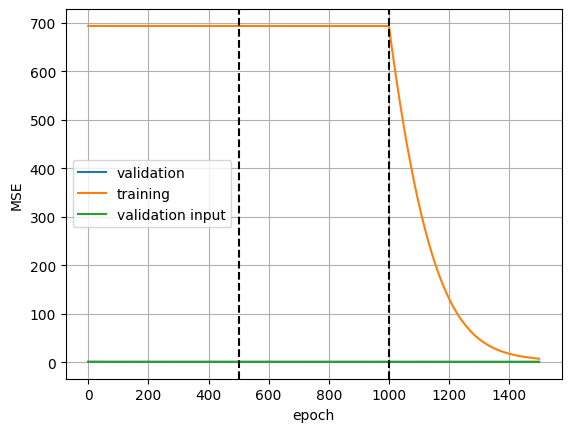

In [12]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [13]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 400 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

,epoch,mse,stage
0,0,1.072231,pre-denoise
1,1,1.063331,pre-denoise
2,2,1.009985,pre-denoise
3,3,1.054199,pre-denoise
4,4,1.039051,pre-denoise
...,...,...,...
1495,1495,0.807182,denoise-smooth-enhance
1496,1496,0.841186,denoise-smooth-enhance
1497,1497,0.832513,denoise-smooth-enhance
1498,1498,0.818343,denoise-smooth-enhance


/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


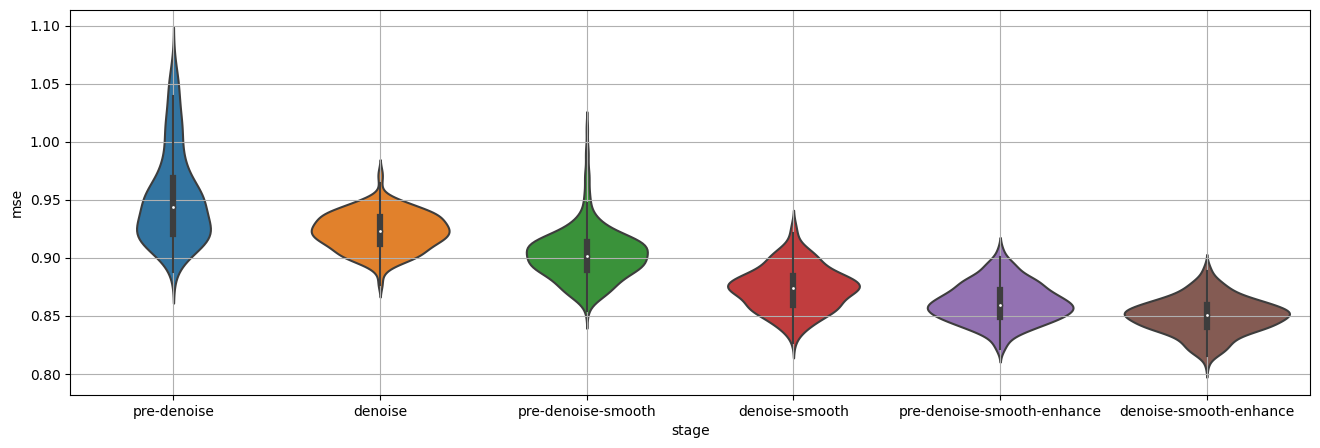

In [14]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()

In [15]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 2.9889686159241233e-75 f = 0.9744160000000001


In [16]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 3.074143128403185e-38 f = 0.834176


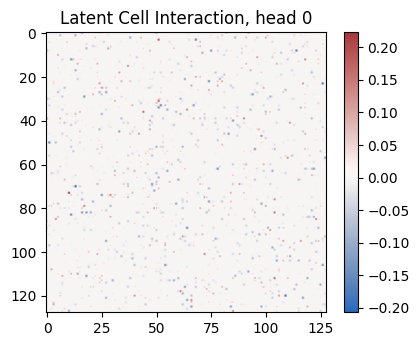

In [17]:
# Plot heatmap of the parameters in cell interaction module

weight_CIs = []
for head in range(len(model.cell_interacts)):
    weight_CIs.append(model.cell_interacts[head].transform.data)

plt.figure(figsize=(10, 8))
for i, weight_CI in enumerate(weight_CIs):
    weight_array = weight_CI.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Latent Cell Interaction, head {i}')
plt.show()

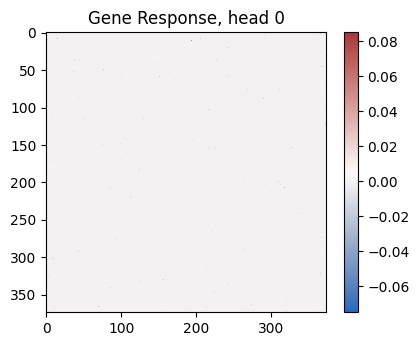

In [18]:
# Plot heatmap of the parameters in gene response module

weight_GRs = []
for head in range(len(model.cell_interacts)):
    weight_GRs.append(model.cell_interacts[head].gene_response.data)

plt.figure(figsize=(10, 8))
for i, weight_GR in enumerate(weight_GRs):
    weight_array = weight_GR.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Gene Response, head {i}')
plt.show()

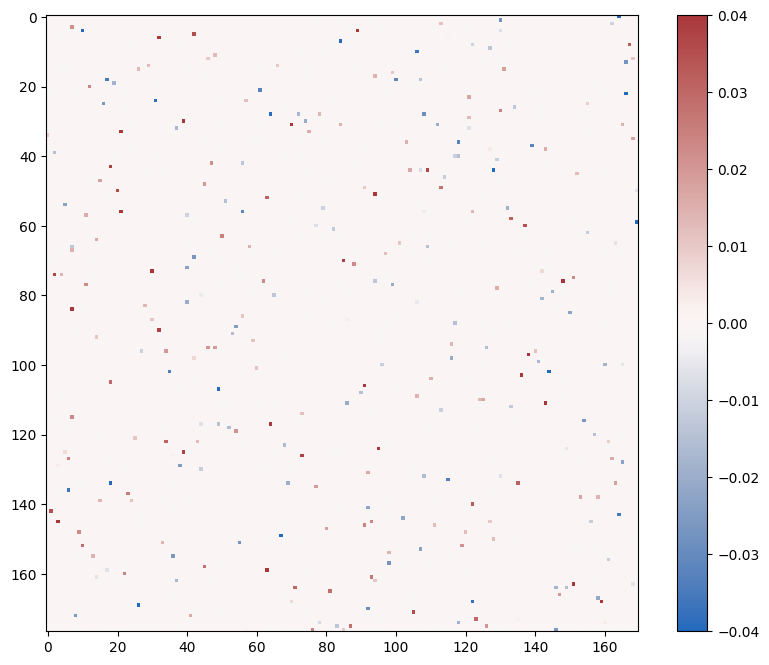

In [27]:
# Extract meaningful weights from Gene Response
THRESHOLD = 0.01

matGR = model.cell_interacts[0].gene_response.data.cpu().numpy()
col_max = np.max(np.abs(matGR), axis=0)
row_max = np.max(np.abs(matGR), axis=1)

meaningfulCols = np.where(col_max > THRESHOLD)[0]
meaningfulRows = np.where(row_max > THRESHOLD)[0]

meaningfulMatGR = matGR[meaningfulRows, :][:, meaningfulCols]

# meaningfulMatGR = np.clip(meaningfulMatGR, -.04, .04)

plt.figure(figsize=(10, 8))
plt.imshow(meaningfulMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()

In [30]:
# Find the indices of highest absolute values in the meaningfulMatGR

topK = 10
topK_indices = np.argsort(np.abs(matGR), axis=None)[-topK:]

topK_indices = np.unravel_index(topK_indices, matGR.shape)

topK_indices

(array([199,   8, 366,  45, 207, 171, 115, 103,  11, 154]),
 array([310, 206,  70, 368, 318,  10,  49, 218, 194, 327]))

In [32]:
np.abs(matGR)[topK_indices]

array([0.05219954, 0.05254349, 0.05571308, 0.05574064, 0.05610193,
       0.05742089, 0.06608786, 0.06866925, 0.07483528, 0.08511941],
      dtype=float32)

In [34]:
# check the corresponding genes

LR_pairs = []

for i in range(topK):
    LR_pairs.append((adata.var.index[topK_indices[1][i]], 
                     adata.var.index[topK_indices[0][i]]))

LR_pairs

[('ENSMUSG00000028373', 'ENSMUSG00000024401'),
 ('ENSMUSG00000034485', 'ENSMUSG00000024411'),
 ('ENSMUSG00000039109', 'ENSMUSG00000020160'),
 ('ENSMUSG00000050711', 'ENSMUSG00000030270'),
 ('ENSMUSG00000021972', 'ENSMUSG00000019772'),
 ('ENSMUSG00000048251', 'ENSMUSG00000016763'),
 ('ENSMUSG00000003476', 'ENSMUSG00000036117'),
 ('ENSMUSG00000074968', 'ENSMUSG00000023206'),
 ('ENSMUSG00000002603', 'ENSMUSG00000031375'),
 ('ENSMUSG00000039087', 'ENSMUSG00000029231')]

In [41]:
import pandas as pd

lr_pairs = pd.read_csv('./mouse_lr_pair.csv')

lgID = lr_pairs['ligand_ensembl_gene_id']
rpID = lr_pairs['receptor_ensembl_gene_id']

lrID = pd.concat([lgID, rpID], axis=1)
# lrID

geneIDBank = set(adata.var.index)

# filter out the genes that are not in the dataset

lrID = lrID[lrID['ligand_ensembl_gene_id'].isin(geneIDBank) &
            lrID['receptor_ensembl_gene_id'].isin(geneIDBank)]
lrID

,ligand_ensembl_gene_id,receptor_ensembl_gene_id
26,ENSMUSG00000035385,ENSMUSG00000049103
50,ENSMUSG00000000869,ENSMUSG00000026770
52,ENSMUSG00000000869,ENSMUSG00000031304
275,ENSMUSG00000017344,ENSMUSG00000026768
323,ENSMUSG00000019772,ENSMUSG00000022206
334,ENSMUSG00000019997,ENSMUSG00000020122
339,ENSMUSG00000019997,ENSMUSG00000030786
467,ENSMUSG00000024164,ENSMUSG00000026616
469,ENSMUSG00000024164,ENSMUSG00000030724
470,ENSMUSG00000024164,ENSMUSG00000030786


Text(0, 0.5, 'Density')

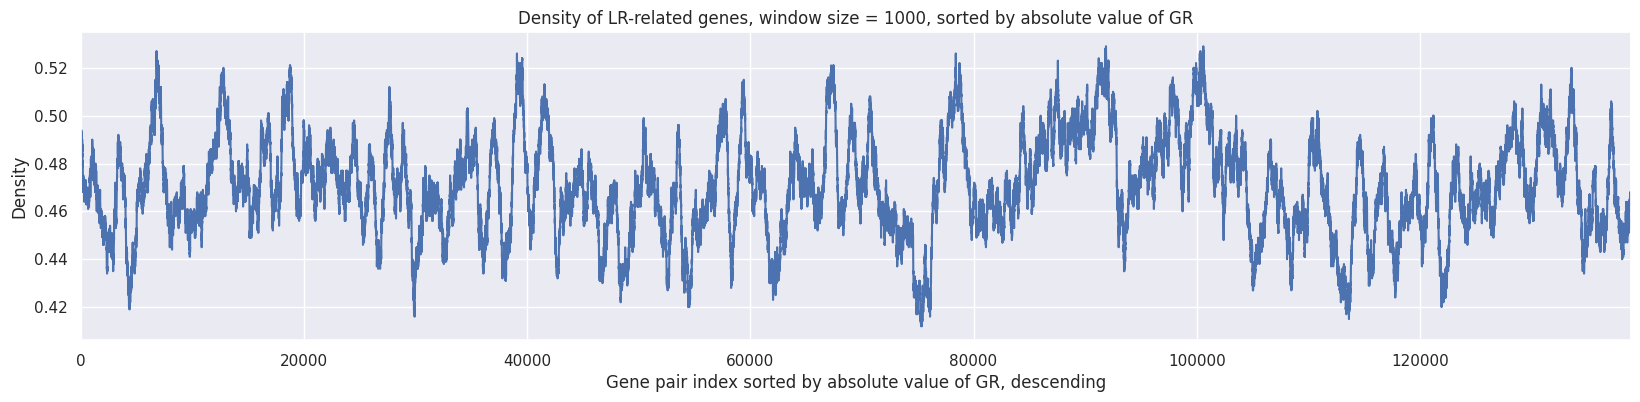

In [53]:
ranked_indices = np.argsort(np.abs(matGR), axis=None)
ranked_indices = np.unravel_index(ranked_indices, matGR.shape)

LR_related_genes = set(lgID) | set(rpID)

hasRelatedGenes = []

for indices in zip(ranked_indices[0], ranked_indices[1]):
    cnt = 0
    if adata.var.index[indices[0]] in LR_related_genes:
        cnt += 1
    if adata.var.index[indices[1]] in LR_related_genes:
        cnt += 1
    hasRelatedGenes.append(cnt)

hasRelatedGenes = np.array(hasRelatedGenes)

WINDOW_SIZE = 1000

density = []

for i in range(len(hasRelatedGenes) - WINDOW_SIZE):
    density.append(np.mean(hasRelatedGenes[i:i + WINDOW_SIZE]))

sns.set()
plt.figure(figsize=(20, 4))
plt.plot(density)
plt.title(f'Density of LR-related genes, window size = {WINDOW_SIZE}, sorted by absolute value of GR')
plt.xlim(0, len(hasRelatedGenes) - WINDOW_SIZE)
plt.xlabel('Gene pair index sorted by absolute value of GR, descending')
plt.ylabel('Density')

In [20]:
genesCol = adata.var_names[meaningfulCols]
genesRow = adata.var_names[meaningfulRows]

genesCol, genesRow

(Index(['ENSMUSG00000018381', 'ENSMUSG00000035783', 'ENSMUSG00000020178',
        'ENSMUSG00000024397', 'ENSMUSG00000037010', 'ENSMUSG00000024411',
        'ENSMUSG00000060802', 'ENSMUSG00000048251', 'ENSMUSG00000031375',
        'ENSMUSG00000036887',
        ...
        'ENSMUSG00000055415', 'ENSMUSG00000053007', 'ENSMUSG00000055761',
        'ENSMUSG00000040612', 'ENSMUSG00000020160', 'ENSMUSG00000038872',
        'ENSMUSG00000050711', 'ENSMUSG00000044647', 'ENSMUSG00000097648',
        'ENSMUSG00000025754'],
       dtype='object', length=170),
 Index(['ENSMUSG00000035783', 'ENSMUSG00000020178', 'ENSMUSG00000038115',
        'ENSMUSG00000037010', 'ENSMUSG00000024411', 'ENSMUSG00000060802',
        'ENSMUSG00000048251', 'ENSMUSG00000031375', 'ENSMUSG00000021835',
        'ENSMUSG00000073418',
        ...
        'ENSMUSG00000045875', 'ENSMUSG00000055761', 'ENSMUSG00000020160',
        'ENSMUSG00000038872', 'ENSMUSG00000050711', 'ENSMUSG00000044647',
        'ENSMUSG00000097648', 'ENSM

In [21]:
meaningfulMatGR.shape

(177, 170)

([<matplotlib.axis.YTick at 0x7fe1bb3b6bd0>,
 [Text(0, 0, 'ENSMUSG00000062372'),
  Text(0, 1, 'ENSMUSG00000050711'),
  Text(0, 2, 'ENSMUSG00000051980'),
  Text(0, 3, 'ENSMUSG00000031375'),
  Text(0, 4, 'ENSMUSG00000038872'),
  Text(0, 5, 'ENSMUSG00000034855'),
  Text(0, 6, 'ENSMUSG00000034584'),
  Text(0, 7, 'ENSMUSG00000048163'),
  Text(0, 8, 'ENSMUSG00000105096'),
  Text(0, 9, 'ENSMUSG00000048387')])

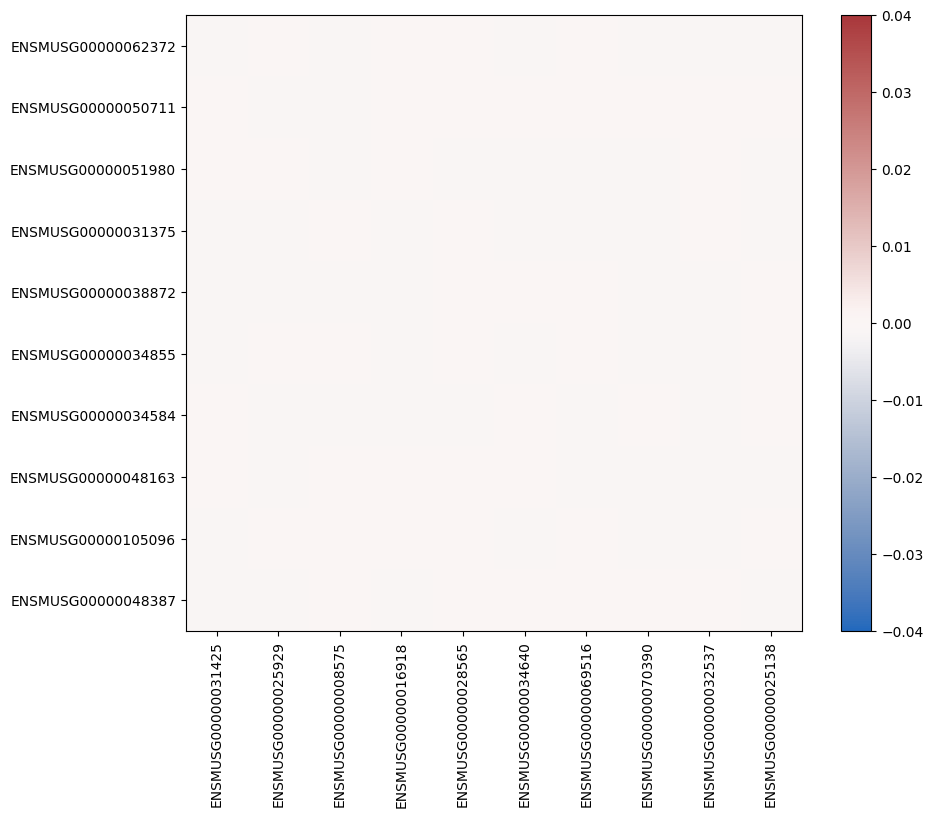

In [22]:
# take out a random patch

PATCH_SIZE = 10

idxCol = np.random.choice(meaningfulMatGR.shape[1], size=PATCH_SIZE, replace=False)
idxRow = np.random.choice(meaningfulMatGR.shape[0], size=PATCH_SIZE, replace=False)

patchMatGR = meaningfulMatGR[idxRow, :][:, idxCol]
patchGeneCol = genesCol[idxCol]
patchGeneRow = genesRow[idxRow]

plt.figure(figsize=(10, 8))
plt.imshow(patchMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()
plt.xticks(range(PATCH_SIZE), patchGeneCol, rotation=90)
plt.yticks(range(PATCH_SIZE), patchGeneRow)

In [23]:
# # take out a random column

# randColIdx = np.random.choice(meaningfulMatGR.shape[1], size=1, replace=False)
# randCol = meaningfulMatGR[:, randColIdx]
# randGene = genesCol[randColIdx]
# meaningfulY = np.abs(randCol) > THRESHOLD

# randCol = randCol[meaningfulY]

# randGene = randGene[meaningfulY]

# plt.figure(figsize=(10, 8))
# plt.imshow(randCol, cmap='vlag', vmin=-.04, vmax=.04)
# plt.colorbar()
# plt.xticks(range(1), randGene, rotation=90)
# plt.yticks(range(meaningfulMatGR.shape[0]), genesRow)